In [1]:
from IPython.display import display, HTML
import scipy.constants as sc
from scipy.optimize import fsolve
from ipywidgets import interact, widgets
%matplotlib notebook

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

14024
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pylib.mix as mix
import pylib.qucf_read as qucf_r
import pylib.qucf_oracle as qucf_o
import pylib.qucf_matrix_D as qucf_m
import ASE as ase
import pylib.qsvt_angles as qsvt_a

for i in range(30):
    plt.close()

In [3]:
# ---------------------------------------------------------------
# --- Read data ---
# ---------------------------------------------------------------
mix.reload_module(ase)

print("\n--- Creating the object with data... ---")
data_ = ase.ASE_()

print("\n--- Reading matrices D from quantum simulations ---")
data_.read_D_matrices()

print("\n\n--- Reading matrices of the considered 1D kinetic problem --") 
data_.read_plasma_matrices()

print("--- Creating a template to extrapolate the matrix D for larger sizes ---") 
data_.create_D_template()


--- Creating the object with data... ---

--- Reading matrices D from quantum simulations ---

Reading the matrix from: flat_33_OUTPUT.hdf5
from the path: ../simulations/KIN1D1D/matrices-D/
date of the simulation:  06-06-2023 09:51:13
matrix name:  U_BE
N = 128

Reading the matrix from: flat_44_OUTPUT.hdf5
from the path: ../simulations/KIN1D1D/matrices-D/
date of the simulation:  06-06-2023 08:57:47
matrix name:  U_BE
N = 512

Reading the matrix from: flat_45_OUTPUT.hdf5
from the path: ../simulations/KIN1D1D/matrices-D/
date of the simulation:  06-23-2023 15:42:09
matrix name:  U_BE
N = 1024

Reading the matrix from: flat_54_OUTPUT.hdf5
from the path: ../simulations/KIN1D1D/matrices-D/
date of the simulation:  06-23-2023 15:48:52
matrix name:  U_BE
N = 1024


--- Reading matrices of the considered 1D kinetic problem --

Reading data from w12/out_3_3_w1.2_Lx100_Lv4_flat.hdf5...
date of the simulation:  06-22-2023 15:48:52
N, nx, nv = 128, 3, 3
Done.

Reading data from out_4_4_w1.2_Lx10

In [4]:
# --------------------------------------------------------------------
# --- Choose a case (matrix size) with which you are going to work ---
# --------------------------------------------------------------------
data_.choose_a_case(nx = 4, nv = 4)

original matrix >>>
amax. value: 			4.000e+00
amin.(excl. zero) value: 	2.855e-04

norm of the matrix:  9.907124260405292

normalized matrix >>>
amax. value: 			3.552e-03
amin.(excl. zero) value: 	2.535e-07



In [5]:
# ---------------------------------------------------------------
# --- Plot the original matrix indicating its structure ---
# ---------------------------------------------------------------
_ = ase.plot_colored_A_structure(
    data_.Nx_work_, data_.Nv_work_, 
    data_.BF_fixed_, data_.BF_prof_, data_.B_CE_, data_.B_Cf_, data_.BS_,
    flag_save = False, 
    path_save = data_.path_save_, 
    fontsize = 20, 
    cmap='bwr'
)

<IPython.core.display.Javascript object>

In [6]:
# ---------------------------------------------------------------
# --- Compute parameters for submatrices ---
# ---------------------------------------------------------------
mix.reload_module(ase)
ase.preliminary_parameters_for_submatrices(data_)

nx: 4
nv: 4


//--- Parameters for the submatrix Cf ---
alpha_0_cf 	-2.841788633538e-02
alpha_1_cf 	3.031241209107e-02

//--- Parameters for the oracle for the submatrix CE ---
alpha_0_CE 	-1.000000000000e+00
alpha_1_CE 	1.066666666667e+00

//--- Parameters for the submatrix S ---
angle_sb 	-0.002131341879
angle_se 	-0.002131344299

//--- Parameters for the submatrix F-prof ---
alpha_0_LFB1 	-0.002131341475
alpha_1_LFB1 	0.002273430907
alpha_0_FL2 	-0.002131341475
alpha_1_FL2 	0.002273430907
alpha_0_FR2 	-0.004262682950
alpha_1_FR2 	0.004546861814
pi2 	6.283185307180


In [37]:
# ---------------------------------------------------------------
# --- Recheck the submatrices --
# ---------------------------------------------------------------
mix.reload_module(ase)
ase.recheck_QuCF_submatrices(data_)

Reading the matrix from: flat_OUTPUT.hdf5
from the path: ../simulations/KIN1D1D/
date of the simulation:  12-24-2023 13:54:38
matrix name:  U_BE
N = 512

--- Cf: QuCF version vs original version ---
The same size of the matrices.
N of nonzero elements = 256
Max. abs. error: 4.781e-07

--- S: QuCF version vs original version ---
The same size of the matrices.
N of nonzero elements = 256
Max. abs. error: 2.175e-13


In [7]:
# ---------------------------------------------------------------------------
# --- Submatrix CE: profile and parameters ---
# ---------------------------------------------------------------------------
from scipy.optimize import least_squares
from scipy.interpolate import CubicSpline

def get_values_at_x1(id_x, values_CE):
    res_values = values_CE[id_x*data_.Nv_work_:(id_x+1)*data_.Nv_work_]
    rows = np.array(range(data_.Nv_work_))
    return res_values, rows

def approx_vH(par):
    return par[1] * x_grid * np.exp(par[0]*x_grid**2)

def comp_residual(par):
    res = np.sum(np.abs(  values_vH - approx_vH(par)  ))
    return [res]
# ---------------------------------------------------------------------------
    
# --- get matrix values of the submatrix CE at one or several spatial points ---
CE_values = data_.B_CE_.get_values()

diag_1, rows_1 = get_values_at_x1(0, CE_values)
diag_2, rows_2 = get_values_at_x1(15, CE_values)
# diag_2, rows_2 = get_values_at_x1(data_.Nx_work_-1, CE_values)

# --- approximate the profile by a function ---
# The parameters do not depend on nx.
values_vH_orig = np.array(diag_1.real)
x_grid_orig  = np.linspace(-1.0, 1.0, len(values_vH_orig))
x_grid  = np.linspace(-1.0, 1.0, 1001)

spl = CubicSpline(x_grid_orig, values_vH_orig)
values_vH = spl(x_grid)

res_approx = least_squares(comp_residual, [-8.0, -6.091e-03], xtol=1e-14)
approx_values_vH = approx_vH(res_approx.x)

print()
print("nx, nv: {:d}, {:d}".format(data_.nx_work_, data_.nv_work_))
print("par_0: {:0.12e}".format(res_approx.x[0]))
print("par_1: {:0.12e}".format(res_approx.x[1]))
print("max-abs-err: {:0.3e}".format(
    np.max(np.abs(
        values_vH_orig - np.interp(x_grid_orig, x_grid, approx_values_vH)
    ))
))

# --- Compare various x ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rows_1, diag_1.real, marker = "o", color='r', linewidth = 2, linestyle='-')
ax.plot(rows_2, diag_2.real, marker = "o", color='b', linewidth = 2, linestyle='--')
plt.xlabel('row')
plt.ylabel("data")
plt.grid(True)
plt.show()

# --- Check approximation ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_grid_orig, values_vH_orig, marker = "o",  color='g', linewidth = 2, linestyle='None')
ax.plot(x_grid, values_vH,        color='r', linewidth = 2, linestyle='-')
ax.plot(x_grid, approx_values_vH, color='b', linewidth = 2, linestyle='--')
plt.xlabel('row')
plt.ylabel("data")
plt.grid(True)
plt.show()

del res_approx, spl


nx, nv: 4, 4
par_0: -7.999999938811e+00
par_1: -6.045363334981e-03
max-abs-err: 1.580e-07


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
nx, nv: 4, 4
par_0: -8.000e+00
par_1: -6.045e-03
max-abs-err: 1.580e-07
    
nx, nv: 4, 5
par_0: -8.000e+00
par_1: -3.029e-03
max-abs-err: 1.060e-08
    
nx, nv: 5, 5
par_0: -8.000e+00
par_1: -3.029e-03
max-abs-err: 1.060e-08

nx, nv: 5, 6
par_0: -8.000e+00
par_1: -1.517e-03
max-abs-err: 4.157e-09

In [120]:
# -----------------------------------------------------------------------------
# --- Submatrix CE: read coefficients and angles for the construction of vH ---
# -----------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qsvt_a)

path_angles = "../simulations/KIN1D1D/vH-angles/"
coef_data = qsvt_a.read_Fourier_coefs(path_angles, "vH_-0.006045_12")
# ang_dd = qsvt_a.read_angles(path_angles, "vH.hdf5");


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_grid_orig,               values_vH_orig, marker = "o",  color='g', linewidth = 2, linestyle='None', label = "ref")
ax.plot(x_grid,                    values_vH,              color='r', linewidth = 2, linestyle='-', label = 'spline')
ax.plot(np.arcsin(coef_data["x"]), coef_data["ref_funct"], color='b', linewidth = 2, linestyle=':', label = 'pol-coefs')
# ax.plot(ang_dd["x"],               ang_dd["pol-angles"] , color='black', linewidth = 2, linestyle=':', label = 'pol-angles')
plt.xlabel('row')
plt.ylabel("data")
plt.legend()
plt.grid(True)
plt.show()


del coef_data, path_angles

when simulated:  12-27-2023 14:28:41

function-type: 		vH
function-parity: 		1
param: 			-0.006045
absolute error: 	6.717e-13
norm. factor: 		1.000e+00
number of coefficients: 15


<IPython.core.display.Javascript object>

Reading the matrix from: flat_OUTPUT.hdf5
from the path: ../simulations/KIN1D1D/
date of the simulation:  12-27-2023 16:12:42
matrix name:  U_BE
N = 512


<IPython.core.display.Javascript object>


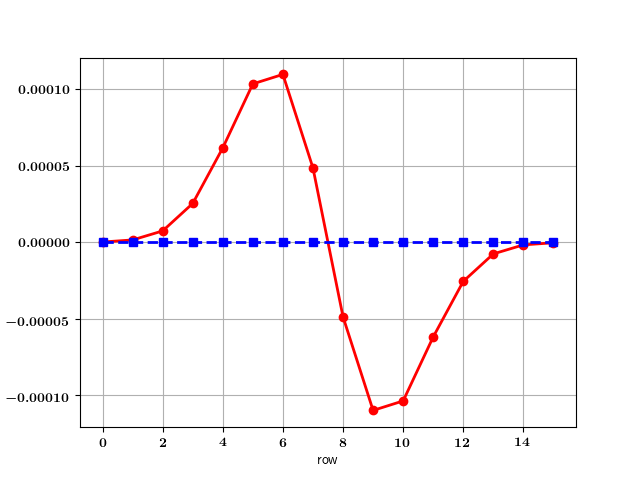

<IPython.core.display.Javascript object>


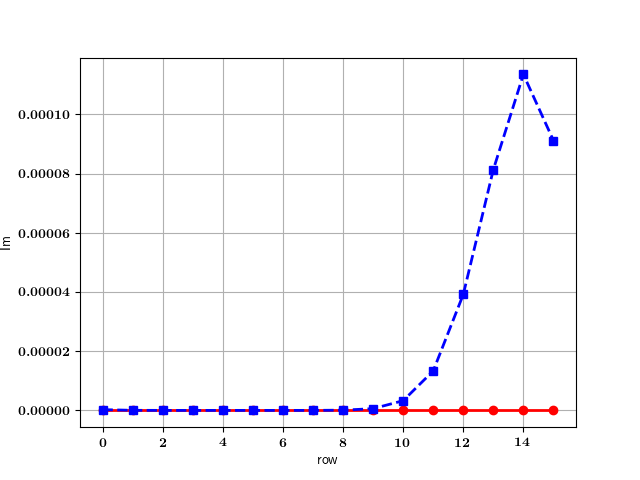

In [8]:
# -----------------------------------------------------------------------------
# --- Submatrix CE: read results from QuCF simulations ---
# -----------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qsvt_a)

id_x = 0

# data from oralce constructor:
CE_values = data_.CE_orig_.get_values()
diag_1, rows_1 = get_values_at_x1(0, CE_values)

# data from QuCF simulations:
dd_qucf = qucf_r.read_matrix_sparse(data_.path_, data_.output_qucf_) 
CE_recon = dd_qucf["A"].get_slice(0, data_.Nvar_work_, data_.Nvar_work_).get_values()
diag_2, rows_2 = get_values_at_x1(0, CE_recon)

# --- Re ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rows_1, diag_1.real, marker = "o", color='r', linewidth = 2, linestyle='-')
ax.plot(rows_2, diag_2.real, marker = "s", color='b', linewidth = 2, linestyle='--')
plt.xlabel('row')
plt.ylabel("Re")
plt.grid(True)
plt.show()

# --- Im ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rows_1, diag_1.imag, marker = "o", color='r', linewidth = 2, linestyle='-')
ax.plot(rows_2, diag_2.imag, marker = "s", color='b', linewidth = 2, linestyle='--')
plt.xlabel('row')
plt.ylabel("Im")
plt.grid(True)
plt.show()


del id_x

Reading the matrix from: flat_OUTPUT.hdf5
from the path: ../simulations/KIN1D1D/
date of the simulation:  12-25-2023 13:10:21
matrix name:  U_BE
N = 512


<IPython.core.display.Javascript object>


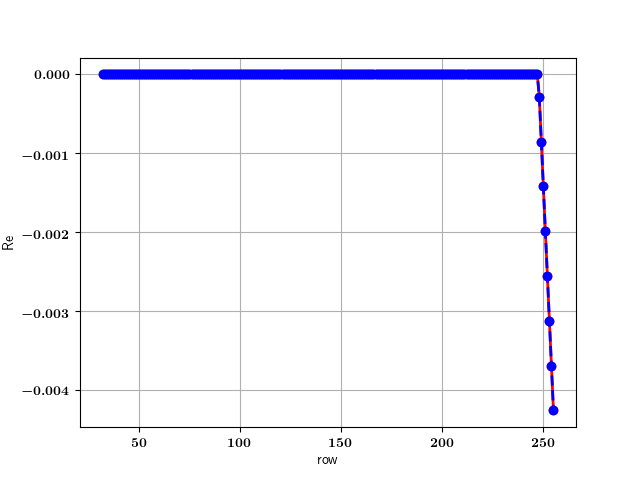

<IPython.core.display.Javascript object>


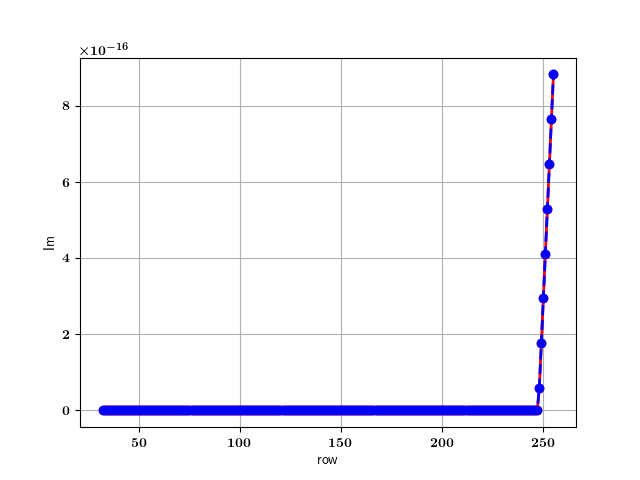

In [11]:
# ---------------------------------------------------------------------------
# --- Print profiles in the submatrix F: compare with the QuCF simulation ---
# ---------------------------------------------------------------------------
def get_diag(A, i_shift):
    N = A.shape[0]
    diag = np.zeros(N-np.abs(i_shift), dtype=A.dtype)
    if i_shift >= 0:
        chosen_range = range(N-i_shift)
        for ir in range(N-i_shift):
            diag[ir] = A[ir, ir + i_shift]
    else:
        chosen_range = range(-i_shift, N)
        for ir in chosen_range:
            diag[ir + i_shift] = A[ir, ir + i_shift]
    row_range = np.array(chosen_range)
    return diag, row_range

# ----------------------------------------------------------

# --- data from the oracle constructor ---
BFP = data_.BF_prof_.form_dense_matrix() # of size Nv*Nx;

diag_1, rows_1 = get_diag(BFP, -2*data_.Nv_work_)
# diag_2, rows_2 = get_diag(BFP, -2*data_.Nv_work_)

# --- data from QuCF simulations ---
dd_qucf = qucf_r.read_matrix_sparse(data_.path_, data_.output_qucf_) 
F_recon = dd_qucf["A"].get_slice(0, 0, data_.Nvar_work_)
_, BFP_recon = ase.extract_fixed_profile_matrix_from_F(
    data_.nx_work_, data_.nv_work_, F_recon, data_.DF_work_
)
BFP_recon = BFP_recon.form_dense_matrix()

diag_2, rows_2 = get_diag(BFP_recon, -2*data_.Nv_work_)

del dd_qucf, F_recon

# --- Real parts ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rows_1, diag_1.real, marker = "o", color='r', linewidth = 2, linestyle='-')
ax.plot(rows_2, diag_2.real, marker = "o", color='b', linewidth = 2, linestyle='--')
plt.xlabel('row')
plt.ylabel("Re")
plt.grid(True)
plt.show()

# --- Imaginary parts ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rows_1, diag_2.imag, marker = "o", color='r', linewidth = 2, linestyle='-')
ax.plot(rows_1, diag_2.imag, marker = "o", color='b', linewidth = 2, linestyle='--')
plt.xlabel('row')
plt.ylabel("Im")
plt.grid(True)
plt.show()

In [5]:
data_.D_work_

AttributeError: 'ASE_' object has no attribute 'D_work_'